# A/B Testing - PA Bond

In [8]:
import numpy as np
import pandas as pd
import pingouin as pg

from statsmodels.stats import api as sms
from scipy import stats

# 0.0 Planejamento

# 1.1 Design do Experimento

- **Objetivo**: Definir se o preencihmento automático da página de checkout é melhor do que o preenchimento manual.
- **Métrica**: GMV ( Gross Margin Reveneu) médio

    - Group A = Preenchimento automático
    - Group B = preenchimento manual
    
    
- Métrica com dispersão naturalmente menor
    - Conversão - (0 - 1)
    - Compras - (0 - Unidades)
    - GMV - (0 - R$ 30.000)

## 1.1 Hipótese do Experimento

- H0: avg GMV A = avg GMV B
- HA: avg GMV A <> avg GMV B
    

## 1.2 Definir o tamanho da amostra

In [13]:
#p1 = 0.75
#p2 = 0.80

#init_metric = metric atual (média do GMV, média Sales)
#end_metric =  metric lift(5% sobre a metric atual)


init_metric = 1902.86
end_metric = init_metric * (1 + 0.05)
std_metric = 1398.89


effect_size  = (end_metric - init_metric) / std_metric

sample_size = sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = 0.05, 
    power = 0.80)

sz = np.ceil(sample_size).astype(int)

print(sz)

3395


# 2.0 Preparação dos dados

## 2.1 Loading data

In [4]:
df = pd.read_csv(r'../data/raw/ab_testing.csv')

In [5]:
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


## 2.2 Descriptive Statistics

In [9]:
df2 = df.loc[df['country'] == 'BRA', :]
df2.head()

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A
31,11172970,BRA,M,1797,3,2017-07-05,GRP B,I
36,11177332,BRA,M,1994,6,2017-01-06,GRP B,I
37,11179295,BRA,M,1198,2,2017-12-19,GRP B,A


In [10]:
df2['spent'].agg(['mean' , 'std'])

mean    1902.860251
std     1398.886279
Name: spent, dtype: float64

In [15]:
print ('Numbers of Rows: {}'. format(df2.shape[0]))
print ('Numbers of Cols: {}'. format(df2.shape[1]))

Numbers of Rows: 9009
Numbers of Cols: 8


### 2.2.1 Check NA

In [16]:
df2.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

### 2.2.2 Check Unidade Experimental (pessoas)

In [17]:
df2[['uid' , 'group']].groupby('uid').count().reset_index().query('group > 1')

,uid,group


### 2.2.3 Control and Treatment Homogenity

In [20]:
df2[['uid' ,'group' ,'gender']].groupby(['group','gender']).count()

uid
group gender      
GRP A F       2213
      M       2305
GRP B F       2208
      M       2283

In [21]:
df2[['uid' ,'group' ,'device']].groupby(['group','device']).count()

uid
group device      
GRP A A       2208
      I       2310
GRP B A       2284
      I       2207

In [23]:
df2.groupby('group').agg({'country' : 'count',
                         'spent' : ['min', 'max' , 'mean' , 'std'],
                         'purchases' : ['min', 'max' , 'mean' , 'std']})

country spent                                  purchases                \
        count   min    max         mean          std       min max      mean   
group                                                                          
GRP A    4518    99  10480  1899.792165  1413.074052         1  24  4.568172   
GRP B    4491    99  10478  1905.946782  1384.617019         1  23  4.585393   

                 
            std  
group            
GRP A  3.170057  
GRP B  3.132202

<AxesSubplot:>

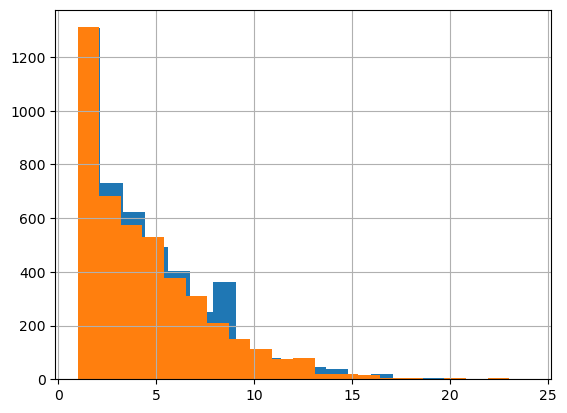

In [26]:
df2.loc[df2['group'] == 'GRP A' , 'purchases'].hist(bins = 20)
df2.loc[df2['group'] == 'GRP B' , 'purchases'].hist(bins = 20)

# 3.0 Teste de Hipótese

## 3.1 Groups

In [32]:
sample_A = df2.loc[df2['group'] == 'GRP A' , 'spent'].sample(sz, random_state = 42)
sample_B = df2.loc[df2['group'] == 'GRP B' , 'spent'].sample(sz, random_state = 42)

In [37]:
# Metrics
print( 'AVG Sample A: {} +/- {}'. format( np.round(sample_A.mean() , 2), np.round(sample_A.std(), 2) ))
print( 'AVG Sample B: {} +/- {}'. format( np.round(sample_B.mean() , 2), np.round(sample_B.std(), 2) ))

AVG Sample A: 1908.56 +/- 1406.42
AVG Sample B: 1902.1 +/- 1383.93


## 3.2 Inferência Estatística

In [38]:
t_test , p_value = stats.ttest_ind (sample_A ,  sample_B)

In [39]:
print ('p_value: {}'.format(p_value))

p_value: 0.8488440918718094


# 4.0 Conslusão

In [40]:
significance_level = 0.05
if p_value < significance_level:
    print('Reject Null Hypothesis')
    print('O preenchimento automático trouxe uma mudança significativa no GMV médio da página')
    print('OK - Podemos liberar a página para toda a audiência do site')
else:
    print('Failed to Reject Null Hypothesis ( Assumir a Hipótese Nula)')
    print('Não temos evidência suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página')
    print('Repensar a estratégia do dispositivo de preenchimento automático')    

Failed to Reject Null Hypothesis ( Assumir a Hipótese Nula)
Não temos evidência suficientes para dizer que o preenchimento automático trouxe uma mudança significativa no GMV médio da página
Repensar a estratégia do dispositivo de preenchimento automático
